In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

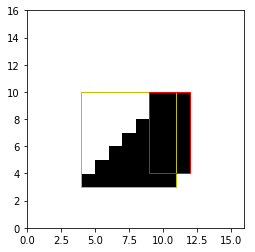

In [3]:
i = 0
# TODO: Why does the array have to be transposed?
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))

In [4]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), -1.1003642441664852e-16, 1.0)

In [5]:
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(50000, 10)

In [6]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

Using TensorFlow backend.


In [10]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def dist(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

num_epochs_flipping = 50
num_epochs_no_flipping = 0  # has no significant effect
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs_flipping + num_epochs_no_flipping))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs_flipping):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for sample, (pred, exp) in enumerate(zip(pred_y, flipped_train_y)):
        
        # TODO: Make this simpler.
        pred = pred.reshape(num_objects, -1)
        exp = exp.reshape(num_objects, -1)
        
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        # TODO: Try flipping array and see if results differ.
        ious = np.zeros((num_objects, num_objects))
        dists = np.zeros((num_objects, num_objects))
        mses = np.zeros((num_objects, num_objects))
        for i, exp_bbox in enumerate(exp_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                ious[i, j] = IOU(exp_bbox, pred_bbox)
                dists[i, j] = dist(exp_bbox, pred_bbox)
                mses[i, j] = np.mean(np.square(exp_bbox - pred_bbox))
                
        new_order = np.zeros(num_objects, dtype=int)
        
        for i in range(num_objects):
            # Find pred and exp bbox with maximum iou and assign them to each other (i.e. switch the positions of the exp bboxes in y).
            ind_exp_bbox, ind_pred_bbox = np.unravel_index(mses.argmin(), mses.shape)
            ious_epoch[sample, epoch] += ious[ind_exp_bbox, ind_pred_bbox]
            dists_epoch[sample, epoch] += dists[ind_exp_bbox, ind_pred_bbox]
            mses_epoch[sample, epoch] += mses[ind_exp_bbox, ind_pred_bbox]
            mses[ind_exp_bbox] = 1000000#-1  # set iou of assigned bboxes to -1, so they don't get assigned again
            mses[:, ind_pred_bbox] = 10000000#-1
            new_order[ind_pred_bbox] = ind_exp_bbox
        
        flipped_train_y[sample] = exp[new_order].flatten()
        
        flipped[sample, epoch] = 1. - np.mean(new_order == np.arange(num_objects, dtype=int))#np.array_equal(new_order, np.arange(num_objects, dtype=int))  # TODO: Change this to reflect the number of flips.
        ious_epoch[sample, epoch] /= num_objects
        dists_epoch[sample, epoch] /= num_objects
        mses_epoch[sample, epoch] /= num_objects
        
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print
    
# print '------------------------------------'
# print 'Training now without flipping bboxes'
# print '------------------------------------'
    
# for epoch in range(num_epochs_flipping, num_epochs_flipping + num_epochs_no_flipping):
#     print 'Epoch', epoch
#     model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#     pred_y = model.predict(train_X)

#     # Calculate iou/dist, but don't flip.
#     for sample, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         pred_bboxes = pred_bboxes.reshape(num_objects, -1)
#         exp_bboxes = exp_bboxes.reshape(num_objects, -1)        
        
#         for exp_bbox, pred_bbox in zip(exp_bboxes, pred_bboxes):
#             ious_epoch[sample, epoch] += IOU(exp_bbox, pred_bbox)
#             dists_epoch[sample, epoch] += dist(exp_bbox, pred_bbox)
#             mses_epoch[sample, epoch] += np.mean(np.square(exp_bbox - pred_bbox))
            
#         ious_epoch[sample, epoch] /= num_objects
#         dists_epoch[sample, epoch] /= num_objects 
#         mses_epoch[sample, epoch] /= num_objects 
            
# #     print 'Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.)
#     print 'Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch]))
#     print 'Mean dist: {}'.format(np.mean(dists_epoch[:, epoch]))
#     print 'Mean mse: {}'.format(np.mean(mses_epoch[:, epoch]))
#     print
    
# TODO: Calculate IOU and dist for validation data during training.

Epoch 0


/Users/andrewabbott/.virtualenvs/dl4cv/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.1577 - val_loss: 0.0568
Flipped 48.8975 % of all elements
Mean IOU: 0.22785939804385502
Mean dist: 0.20229541698117953
Mean mse: 0.017306232257727417
Epoch 1
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0562 - val_loss: 0.0503
Flipped 28.634999999999998 % of all elements
Mean IOU: 0.2652422624688664
Mean dist: 0.18539639006863295
Mean mse: 0.014237510183384672
Epoch 2
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
3s - loss: 0.0494 - val_loss: 0.0484
Flipped 18.584999999999997 % of all elements
Mean IOU: 0.30461728704618113
Mean dist: 0.16515404972498782
Mean mse: 0.012028163319127308
Epoch 3
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0449 - val_loss: 0.0488
Flipped 11.1425 % of all elements
Mean IOU: 0.3454508223412438
Mean dist: 0.14578802087608234
Mean mse: 0.01015507355832527
Epoch 4
Train on 40000 samples, validate on 10000 samples
Epoch 1

Flipped 2.2375 % of all elements
Mean IOU: 0.5243686897369456
Mean dist: 0.08040046791881555
Mean mse: 0.004456855947582554
Epoch 36
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0217 - val_loss: 0.0554
Flipped 2.1825 % of all elements
Mean IOU: 0.5287882892990374
Mean dist: 0.08010461993112077
Mean mse: 0.004455663471514961
Epoch 37
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0215 - val_loss: 0.0553
Flipped 2.1875 % of all elements
Mean IOU: 0.5260603056920631
Mean dist: 0.07994026646768859
Mean mse: 0.004416976174760126
Epoch 38
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0214 - val_loss: 0.0556
Flipped 2.16 % of all elements
Mean IOU: 0.5314003588023648
Mean dist: 0.07934276724106978
Mean mse: 0.004376727230091499
Epoch 39
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
2s - loss: 0.0214 - val_loss: 0.0556
Flipped 2.4775 % of all elements
Mean IOU: 0.5311890339974686
Mean dist: 0.0787356

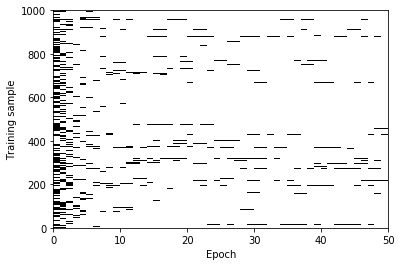

In [11]:
plt.pcolor(flipped[:1000], cmap='Greys', vmax=1.)
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0, 1)

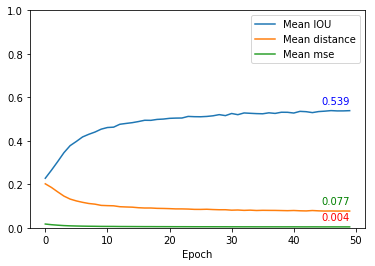

In [12]:
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')  # relative to image size
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')
# plt.axvline(num_epochs_flipping, c='r')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 1)

# plt.savefig('plots/bw-multiple-rectangles-mse.png', dpi=300)

In [13]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 2, 4), (10000, 2, 1))

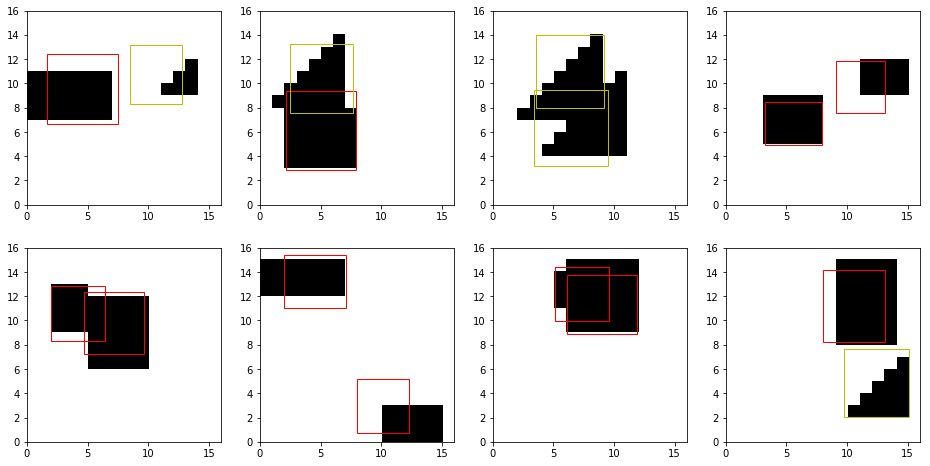

In [14]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')